In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import pickle
import tifffile
import sys
from astropy.visualization import AsymmetricPercentileInterval, LogStretch, MinMaxInterval


In [48]:
WORKDIR='/home/daniel/gdrive/EPFL/2019-2020/MachineLearning/Project/gravitational_lens_ml'
SRC = os.path.join(WORKDIR, 'src')
DATA = os.path.join(WORKDIR,'data')
RESULTS = os.path.join(WORKDIR, 'results')
TRAIN = os.path.join(DATA, 'datapack2.0train/Public')
TEST = os.path.join(DATA, 'datapack2.0test/Public')
TRAIN_MULTIBAND = os.path.join(DATA, 'train_multiband_bin')
TRAIN_MULTIBAND_NOCLIP = os.path.join(DATA, 'train_multiband_noclip_bin')
TEST_MULTIBAND = os.path.join(DATA, 'test_multiband')
CHECKPOINTS = os.path.join(RESULTS, 'checkpoints')

In [4]:
image_catalog = pd.read_csv(os.path.join(DATA, 'catalog/image_catalog2.0train.csv'), comment='#', index_col=0)
print(image_catalog.shape)
display(image_catalog.isna().sum(axis=0))
# No effective magnification for 11182 records.

(100009, 26)


ID                  0
x_crit              0
y_crit              0
source_ID           0
z_source            0
z_lens              0
mag_source          0
ein_area            0
n_crit              0
r_source            0
crit_area           0
n_pix_source        0
source_flux         0
n_pix_lens          0
lens_flux           0
n_source_im         0
mag_eff         11182
sb_contrast         0
color_diff          0
n_gal_3             0
n_gal_5             0
n_gal_10            0
halo_mass           0
star_mass           0
mag_lens            0
n_sources           0
dtype: int64

In [5]:
band = 'EUC_VIS'
def get_file_id(filename, delimiters = '_|\.|-'):
    id_ = [int(s) for s in re.split(delimiters, filename) if s.isdigit()][0]
    return id_
file_id_train = np.array([get_file_id(f) for f in os.listdir(os.path.join(TRAIN, band))], dtype=int)
file_id_test = np.array([get_file_id(f) for f in os.listdir(os.path.join(TEST, band))], dtype=int)
def check_existing_files(band, set_):
    for ID in image_catalog.ID:
        if not os.path.isfile(os.path.join(set_, band,'image%s-%i.fits'%(band, ID))):
            print('File image%s-%i.fits does not exist in set.'%(band, ID))
missing_img =  np.setdiff1d(image_catalog.ID.values, file_id_train, assume_unique=False)
print(file_id_train.shape)
print(missing_img)

(99991,)
[213913 226305 233597 244071 259871 261145 270458 288731 294173]


In [6]:
image_catalog['is_lens'] = (image_catalog['mag_lens'] > 1.2) & (image_catalog['n_sources'] != 0)
print('Number of lenses: %i'%image_catalog['is_lens'].sum())

Number of lenses: 90003


In [7]:
image_catalog['img_exists'] = True
image_catalog['img_exists'].loc[image_catalog['ID'].isin(missing_img)] = False

/home/daniel/anaconda3/envs/gravitational_lens_ml/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
image_catalog = image_catalog.drop_duplicates('ID')

In [24]:
lens_cat = image_catalog[image_catalog['is_lens']==True]
nonlens_cat = image_catalog[image_catalog['is_lens']==False]

In [25]:
print('Lenses: %i'%len(image_catalog[image_catalog['is_lens']==True]))
print('Non-lenses: %i'%len(image_catalog[image_catalog['is_lens']==False]))

Lenses: 89995
Non-lenses: 10005


In [49]:
example_lens=lens_cat.iloc[0,0]
example_nonlens=nonlens_cat.iloc[0,0]
print(example_lens, example_nonlens)

200001 200003


In [29]:
import aplpy 
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

In [87]:
def get_image_filename_from_id(id_, band, set_=TRAIN, ext='fits'):
    fname = os.path.join(set_, '{0}/image{0}-{1}.{2}'.format(band, id_, ext))
    return fname


def plot_all_bands_from_id(id_,
                           fig=fig,
                           pmin=0,
                           pmax=100,
                           subplot_line=1,
                           total_subplot_lines=1):
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    fitsfigs = []
    data = []
    for i, band in enumerate(bands):
        subplot_id = np.ravel_multi_index((subplot_line - 1, i),
                                          (subplot_line, 4)) + 1
        with fits.open(get_image_filename_from_id(id_, band)) as hdu:
            data.append(hdu[0].data)
        fitsfigs.append(
            aplpy.FITSFigure(data[i],
                             figure=fig,
                             subplot=(total_subplot_lines, 4, subplot_id)))
        fitsfigs[i].show_colorscale(pmin=pmin, pmax=pmax)
        fitsfigs[i].set_theme('publication')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()


def plot_all_bands_from_array(id_,
                              fig=fig,
                              pmin=0,
                              pmax=100,
                              path=TRAIN_MULTIBAND,
                              subplot_line=1,
                              total_subplot_lines=1):
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    image_path = os.path.join(path, 'image_%i_multiband.npy' % id_)
    image = np.load(image_path)
    fitsfigs = []
    for i, band in enumerate(bands):
        subplot_id = np.ravel_multi_index((subplot_line - 1, i),
                                          (subplot_line, 4)) + 1
        fitsfigs.append(
            aplpy.FITSFigure(image[:, :, i],
                             figure=fig,
                             subplot=(total_subplot_lines, 4, subplot_id)))
        fitsfigs[i].show_colorscale(pmin=pmin, pmax=pmax)
        fitsfigs[i].set_theme('publication')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()

INFO: Auto-setting vmin to -1.588e-11 [aplpy.core]
INFO: Auto-setting vmax to  1.522e-10 [aplpy.core]


INFO: Auto-setting vmin to -6.783e-10 [aplpy.core]
INFO: Auto-setting vmax to  7.104e-09 [aplpy.core]


INFO: Auto-setting vmin to -3.888e-10 [aplpy.core]
INFO: Auto-setting vmax to  3.987e-09 [aplpy.core]


INFO: Auto-setting vmin to -5.284e-10 [aplpy.core]
INFO: Auto-setting vmax to  5.371e-09 [aplpy.core]


INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to  7.267e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.016e+00 [aplpy.core]


INFO: Auto-setting vmin to  6.586e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.044e+00 [aplpy.core]


INFO: Auto-setting vmin to -6.400e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.074e+00 [aplpy.core]


INFO: Auto-setting vmin to -7.883e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.019e+00 [aplpy.core]


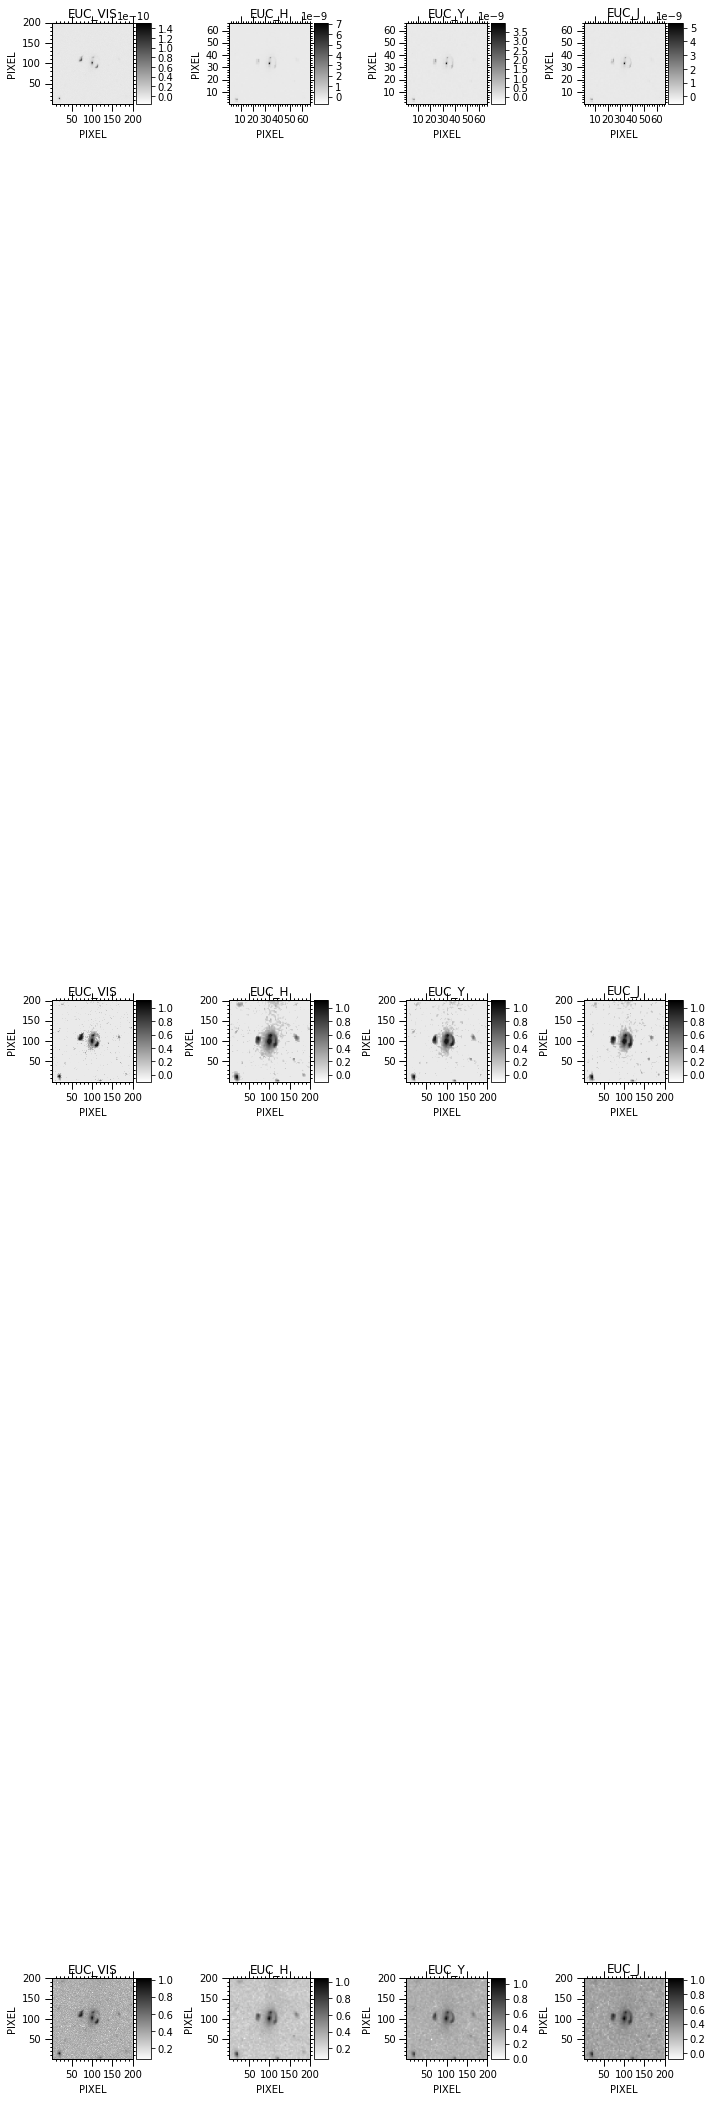

In [88]:
fig = plt.figure(figsize=(10, 50))
plot_all_bands_from_id(example_lens,
                       fig,
                       subplot_line=1,
                       total_subplot_lines=3)
plot_all_bands_from_array(example_lens,
                          fig,
                          subplot_line=2,
                          total_subplot_lines=3,
                          path=TRAIN_MULTIBAND)
plot_all_bands_from_array(example_lens,
                          fig,
                          subplot_line=3,
                          total_subplot_lines=3,
                          path=TRAIN_MULTIBAND_NOCLIP)
fig.tight_layout()

# Combine bands into `tiff` and test

In [52]:
def build_image(id_, set_, bands = ['EUC_VIS', 'EUC_H', 'EUC_J', 'EUC_Y'], img_size=200, scale = 100):
    tables = []
    data = np.empty((img_size, img_size, len(bands)))
    for i, band in enumerate(bands):
        tables.append(fits.open(get_image_filename_from_id(id_, band)))
        if band != 'EUC_VIS':
            band_data, data_footprint = reproject_interp(tables[i][0], tables[0][0].header)
        else:
            band_data = tables[0][0].data
        band_data[np.isnan(band_data)] = 0.
        interval = AsymmetricPercentileInterval(0.25, 99.75, n_samples=100000)
        vmin, vmax = interval.get_limits(band_data)
        stretch = MinMaxInterval() +  LogStretch()
        data[:,:,i] = stretch(((np.clip(band_data, vmin*(-0.7), vmax))/(vmax)))
    for t in tables:
        t.close()
    return data.astype(np.float32)


640128
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
2033    True
Name: is_lens, dtype: bool


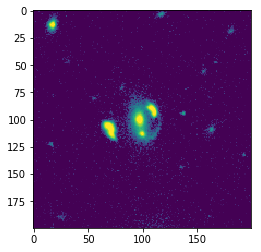

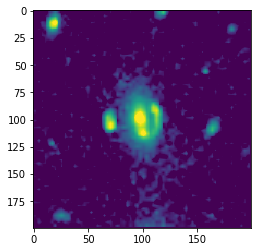

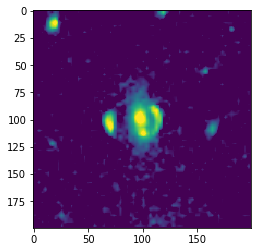

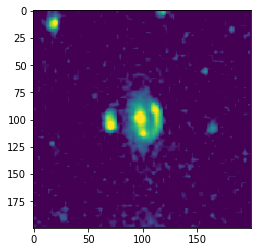

In [53]:
img = build_image(example_lens, TRAIN)
print(sys.getsizeof(img))
for i in range(4):
    plt.figure()
    print(np.min(img[:,:,i]), np.max(img[:,:,i]))
    a = plt.imshow((img[:,:,i]))
print(image_catalog.loc[image_catalog['ID']==270210]['is_lens'])

# Compare preprocessing with Log + Norm

In [ ]:
def build_image_noprocess(id_, set_, bands = ['EUC_VIS', 'EUC_H', 'EUC_J', 'EUC_Y'], img_size=200, scale = 100):
    tables = []
    data = np.empty((img_size, img_size, len(bands)))
    for i, band in enumerate(bands):
        tables.append(fits.open(get_image_filename_from_id(id_, band)))
        if band != 'EUC_VIS':
            band_data, data_footprint = reproject_interp(tables[i][0], tables[0][0].header)
        else:
            band_data = tables[0][0].data
        band_data[np.isnan(band_data)] = 0.
        norm =  LogStretch() + MinMaxInterval()
        data[:,:,i] = norm(band_data)
    for t in tables:
        t.close()
    return data.astype(np.float32)


In [ ]:
test_id = 270210
img = build_image(test_id, TRAIN)
img_nopr = build_image_noprocess(test_id, TRAIN)
def plot_slice(image, slice_ratio, axis=0):
    '''Plot a single slice of a picture.
    
    image: Image to plot.
    slice_ratio: float from 0 to 1 where 0 is the top slice, and 1 is the last slice.
    axis: 0 or 1 to show horizontal or vertical slices'''
    
    index = int(image.shape[axis] * slice_ratio)
    slice_ = image[index]
    plt.plot(slice_)


In [ ]:
plot_slice(img, 0.5)
plt.figure()
plot_slice(img_nopr, 0.5)

In [ ]:
def plot_slice_stack(image, axis=0):
    '''Plot a single slice of a picture.
    
    image: Image to plot.'''
    
    slice_ = np.sum(image, axis=axis)
    print(slice_.shape)
    plt.plot(slice_)

In [ ]:
axis = 0
plot_slice_stack(img, axis = axis)
plt.figure()
plot_slice_stack(img_nopr, axis = axis)

# PCA

In [ ]:
img = tifffile.imread(DATA+'/train_multiband/image_299896_multiband.tiff')
def flatten_by_channel(original_image):
    """preprocess the image."""
    n_channels = original_image.shape[-1]
    processed_image = original_image.reshape(-1,n_channels)
    return processed_image.astype(np.float32) #Overflow if using unsigned int
flat_img = flatten_by_channel(img)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca = PCA(whiten=False)
std_flat_img = scaler.fit_transform(flat_img)
pca.fit(std_flat_img)

In [ ]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [ ]:
pca_flat_img = pca.fit_transform(std_flat_img)
pca_image = pca_flat_img.reshape((img.shape[0], img.shape[1], -1))

In [ ]:
f, ax = plt.subplots(2, 2, figsize = (7, 7))
for i, a in enumerate(ax.ravel()):
    a.imshow(pca_image[:,:,i])

## Covariance Matrix between colors
See, that it is almost diagonal. Not surprising that PC's are almost the same as the priginal colors.

In [ ]:
plt.imshow(np.cov(flat_img.T))

# Check History of model training

In [ ]:
history_path = os.path.join(RESULTS,
                            'gravlens_ResNet20v1_model.epoch025.history')
with open(history_path, 'rb') as handle:
    history = pickle.load(handle)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(range(len(history['loss'])),
         history['val_loss'],
         label='Validation loss',
         marker='o',
         c='b')
ax1.plot(range(len(history['loss'])),
         history['loss'],
         label='Training loss',
         marker='o',
         c='r')
ax2.plot(range(len(history['loss'])),
         history['val_acc'],
         label='Validation accuracy',
         marker='o',
         c='b',
         ls='--',
         fillstyle='none')
ax2.plot(range(len(history['loss'])),
         history['acc'],
         label='Training accuracy',
         marker='o',
         c='r',
         ls='--',
         fillstyle='none')
ax1.set_xlabel('Epoch')
ax1.legend(loc=(-0.1, 1))
ax2.legend(loc=(0.9, 1))
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0,1)
plt.gcf()
plt.savefig(os.path.join(
    RESULTS,
    'plots/' + os.path.basename(history_path).replace('.history', '.png')),
            dpi=200)

In [ ]:
train_tpr = np.array(history['tp'])/(np.array(history['tp']) + np.array(history['fn']))
train_fpr = np.array(history['fp'])/(np.array(history['tn']) + np.array(history['fp']))
val_tpr = np.array(history['val_tp'])/(np.array(history['val_tp']) + np.array(history['val_fn']))
val_fpr = np.array(history['val_fp'])/(np.array(history['val_tn']) + np.array(history['val_fp']))
plt.plot(train_fpr, train_tpr, 'ob', label = 'Train')
plt.plot(val_fpr, val_tpr, 'or', label = 'Validation')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1], [0,1])
plt.legend()

In [ ]:
history.keys()